### Import Library


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow import keras




In [147]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("hassnataslam/pima-indians-diabetes-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pima-indians-diabetes-dataset


In [148]:
diabetes_df = pd.read_csv(os.path.join(path, "diabetes.csv"))
print(diabetes_df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


1. Pregnancies: To express the Number of pregnancies
2. Glucose: To express the Glucose level in blood
3. BloodPressure: To express the Blood pressure measurement
4. SkinThickness: To express the thickness of the skin
5. Insulin: To express the Insulin level in blood
6. BMI: To express the Body mass index
7. DiabetesPedigreeFunction: To express the Diabetes percentage
8. Age: To express the age
9. Outcome: To express the final result 1 is Yes and 0 is No

#EDA

## Mendefinisikan Pertanyaan


1. Berapa banyak entri dalam dataset dan berapa proporsi dari masing-masing nilai Outcome (0 dan 1)?
2. Bagaimana Korelasi tiap Variabel?
3. Variabel apa yang memiliki korelasi paling tinggi dengan outcome?

## Accesing data and Cleaning


In [149]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [150]:
diabetes_df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [151]:
diabetes_df.duplicated().sum()

np.int64(0)

In [152]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [153]:
# Menghapus Outlier
numerical_columns = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

for column in numerical_columns:
    Q1 = diabetes_df[column].quantile(0.25)
    Q3 = diabetes_df[column].quantile(0.75)
    IQR = Q3 - Q1

    maximum = Q3 + (1.5 * IQR)
    minimum = Q1 - (1.5 * IQR)

    # Menentukan kondisi untuk outlier
    kondisi_lower_than = diabetes_df[column] < minimum
    kondisi_more_than = diabetes_df[column] > maximum

    # Menghapus outlier dari DataFrame
    diabetes_df.drop(diabetes_df[kondisi_lower_than].index, inplace=True)
    diabetes_df.drop(diabetes_df[kondisi_more_than].index, inplace=True)

# Menampilkan DataFrame setelah menghapus outlier
max_min_summary = diabetes_df[numerical_columns].agg(['min', 'max']).transpose()

# Menampilkan hasil
print(max_min_summary)


                             min      max
Pregnancies                0.000   13.000
Glucose                   44.000  198.000
BloodPressure             38.000  106.000
SkinThickness              0.000   60.000
Insulin                    0.000  330.000
BMI                       18.200   49.600
DiabetesPedigreeFunction   0.078    1.162
Age                       21.000   65.000


<ipython-input-153-d7a90475a42a>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diabetes_df.drop(diabetes_df[kondisi_more_than].index, inplace=True)
<ipython-input-153-d7a90475a42a>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diabetes_df.drop(diabetes_df[kondisi_more_than].index, inplace=True)
<ipython-input-153-d7a90475a42a>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diabetes_df.drop(diabetes_df[kondisi_more_than].index, inplace=True)


In [154]:
diabetes_df['Pregnancies'].agg(['min', 'max'])

,Pregnancies
min,0
max,13


## Uji korelasi

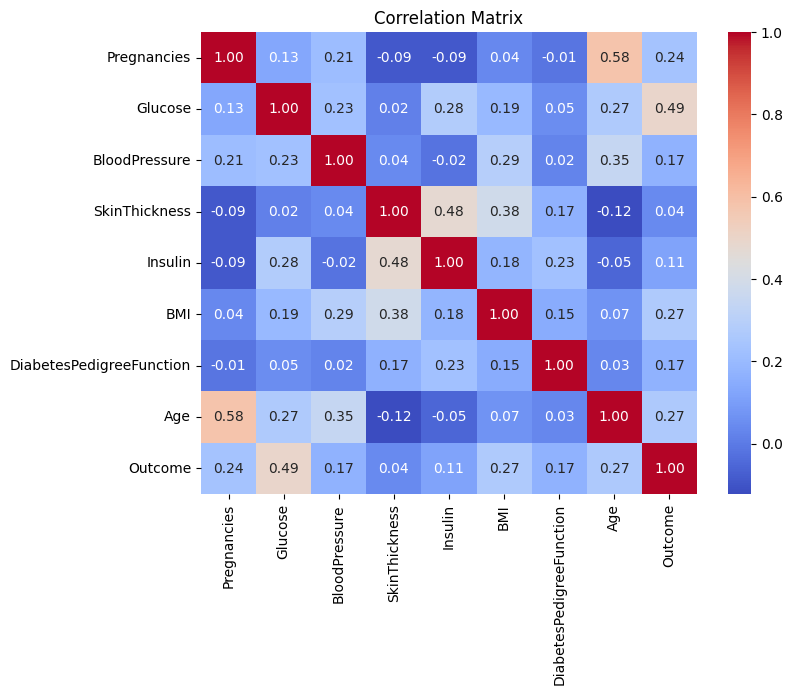

In [155]:
correlation_matrix=diabetes_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [156]:
diabetes_df.groupby('Outcome').agg(
    Pregnancies_mean=('Pregnancies', 'mean'),
    Glucose_mean=('Glucose', 'mean'),
    BloodPressure_mean=('BloodPressure', 'mean'),
    SkinThickness_mean=('SkinThickness', 'mean'),
    Insulin_mean=('Insulin', 'mean'),
    BMI_mean=('BMI', 'mean'),
    DiabetesPedigreeFunction_mean=('DiabetesPedigreeFunction', 'mean'),
    Age_mean=('Age', 'mean'))


,Pregnancies_mean,Glucose_mean,BloodPressure_mean,SkinThickness_mean,Insulin_mean,BMI_mean,DiabetesPedigreeFunction_mean,Age_mean
Outcome,,,,,,,,
0,3.273349,109.293850,70.712984,20.312073,62.601367,30.817768,0.398658,30.610478
1,4.928934,140.208122,74.893401,21.710660,83.314721,34.518782,0.487695,36.888325


## Data Vizualitation and Explanatory analysis

### Data Visualitation

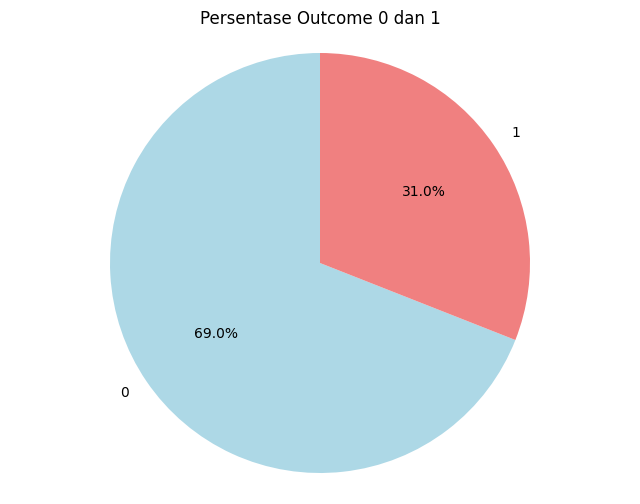

In [157]:
# Menghitung jumlah untuk setiap nilai Outcome
outcome_counts = diabetes_df['Outcome'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Persentase Outcome 0 dan 1')
plt.axis('equal')  # Agar pie chart berbentuk lingkaran

# Menampilkan plot
plt.show()

In [158]:
# Menghitung jumlah orang yang terkena diabetes berdasarkan jumlah kehamilan
diabetes_by_pregnancies = diabetes_df[diabetes_df['Outcome'] == 1].groupby('Pregnancies').size()

# Menampilkan hasil
print(diabetes_by_pregnancies)

Pregnancies
0     24
1     20
2     12
3     23
4     17
5     17
6     12
7     21
8     16
9     14
10     9
11     5
12     4
13     3
dtype: int64


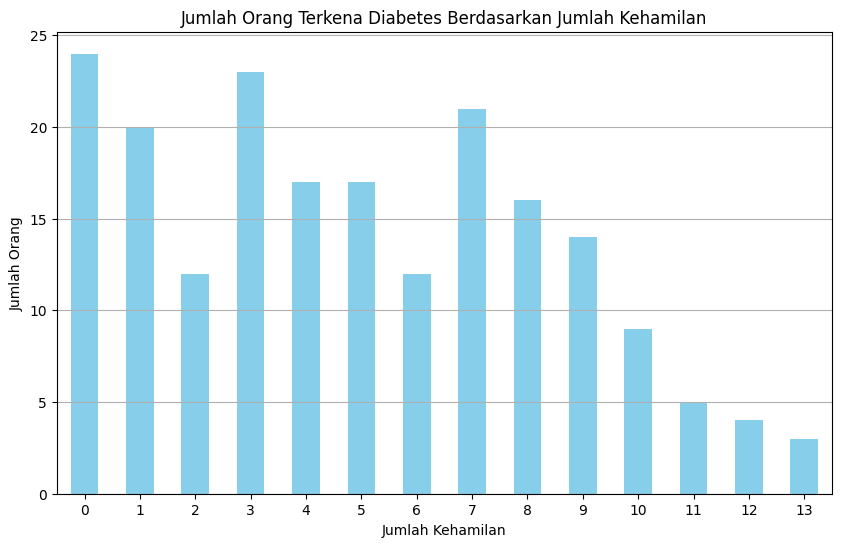

In [159]:
# Membuat visualisasi
plt.figure(figsize=(10, 6))
diabetes_by_pregnancies.plot(kind='bar', color='skyblue')
plt.title('Jumlah Orang Terkena Diabetes Berdasarkan Jumlah Kehamilan')
plt.xlabel('Jumlah Kehamilan')
plt.ylabel('Jumlah Orang')
plt.xticks(rotation=0)  # Memutar label sumbu x agar lebih mudah dibaca
plt.grid(axis='y')

# Menampilkan plot
plt.show()

<ipython-input-160-b319b9b6ba37>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Outcome', y='Glucose', data=diabetes_df, jitter=True, palette='Set2', alpha=0.6)


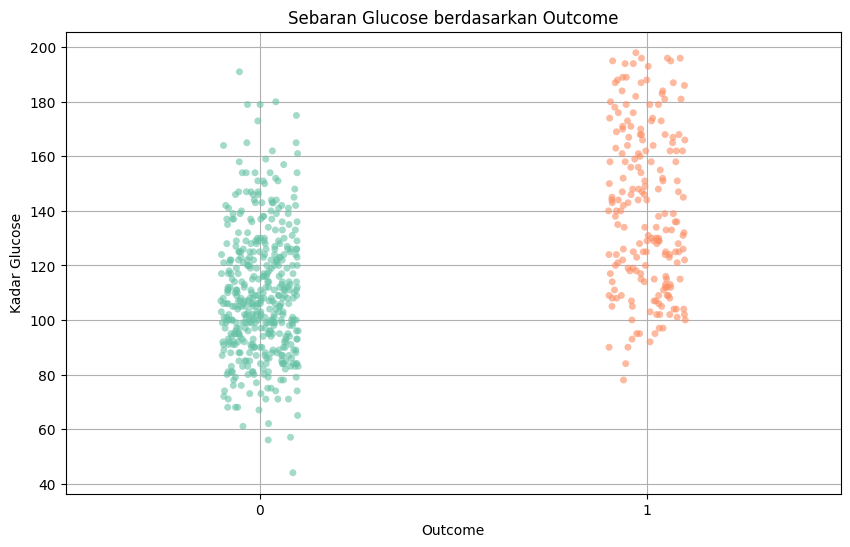

In [160]:
# Membuat strip plot untuk Glucose berdasarkan Outcome
plt.figure(figsize=(10, 6))
sns.stripplot(x='Outcome', y='Glucose', data=diabetes_df, jitter=True, palette='Set2', alpha=0.6)
plt.title('Sebaran Glucose berdasarkan Outcome')
plt.xlabel('Outcome')
plt.ylabel('Kadar Glucose')
plt.grid(True)

# Menampilkan plot
plt.show()

### Explanatory Analysis

**Kesimpulan**
1. Variabel yang memiliki korelasi paling tinggi dengan Outcome (Hasil akhir, di mana 1 menunjukkan pasien menderita diabetes dan 0 menunjukkan pasien tidak menderita diabetes) adalah Glucose (kadar gula darah) dalam pasien.
2. Dan yang memiliki Korelasi paling rendah adalah SkinThickness: Ketebalan lipatan kulit triceps (mm).

**Saran**
1. Penting untuk mempertimbangkan apakah SkinThickness akan digunakan atau tidak
2. Penambahan data dalam dataset bila akurasi yang didapatkan cukup rendah

# Preprocessing


In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib


**Mengisi nilai yang memiliki nilai 0**

In [162]:
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  # Replace with your desired columns

for column in columns_to_check:
  zero_rows = diabetes_df[diabetes_df[column] == 0]
  print(f"Rows with 0 in '{column}':\n{zero_rows}\n")



Rows with 0 in 'Glucose':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'BloodPressure':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'SkinThickness':
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
2              8      183             64              0        0  23.3   
5              5      116             74              0        0  25.6   
10             4      110             92              0        0  37.6   
11            10      168             74              0        0  38.0   
17             7      107             74              0        0  29.6   
..           ...      ...            ...            ...      ...   ...   
749            6      162             62              0        0  24.3   
757            0      123       

In [163]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_df[cols_with_zero] = diabetes_df[cols_with_zero].replace(0, np.nan)

In [164]:
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  # Replace with your desired columns

for column in columns_to_check:
  zero_rows = diabetes_df[diabetes_df[column] == 0]
  print(f"Rows with 0 in '{column}':\n{zero_rows}\n")

Rows with 0 in 'Glucose':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'BloodPressure':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'SkinThickness':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'Insulin':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

Rows with 0 in 'BMI':
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []



**Feature Scaling**

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Modeling

## **Pemisahan Dataset** <br>



Train dan Test,
80% data untuk train dan 20% untuk test.

In [166]:
X = diabetes_df.drop(columns='Outcome', axis=1)
y = diabetes_df['Outcome']

# Split dengan stratifikasi agar distribusi kelas seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [167]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer  # Import SimpleImputer


In [168]:
# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train = imputer.fit_transform(X_train) # Fit and transform on training data
X_test = imputer.transform(X_test) # Transform test data using the trained imputer


## **Pemilihan Metode Model**

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Untuk menyimpan hasil
model_results = {}


In [206]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Simpan skor ke dict
    model_results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }


In [207]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
evaluate_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)

# 2. Decision Tree
dt = DecisionTreeClassifier()
evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)

# 3. Random Forest
rf = RandomForestClassifier()
evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)

# 4. K-Nearest Neighbors
knn = KNeighborsClassifier()
evaluate_model("K-Nearest Neighbors", knn, X_train, y_train, X_test, y_test)

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# 5. AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
evaluate_model("AdaBoost", ada, X_train, y_train, X_test, y_test)

# 6. Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("Gradient Boosting", gb, X_train, y_train, X_test, y_test)

# Pastikan xgboost sudah terinstall dulu: pip install xgboost
from xgboost import XGBClassifier

# 7. XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model("XGBoost", xgb, X_train, y_train, X_test, y_test)




Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        88
           1       0.67      0.55      0.60        40

    accuracy                           0.77       128
   macro avg       0.74      0.71      0.72       128
weighted avg       0.77      0.77      0.77       128

Confusion Matrix:
 [[77 11]
 [18 22]]

Decision Tree Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        88
           1       0.56      0.47      0.51        40

    accuracy                           0.72       128
   macro avg       0.67      0.65      0.66       128
weighted avg       0.71      0.72      0.71       128

Confusion Matrix:
 [[73 15]
 [21 19]]

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        88
           1       0.65      0.42      0.52        40

    accuracy       

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:21:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        88
           1       0.60      0.53      0.56        40

    accuracy                           0.74       128
   macro avg       0.70      0.68      0.69       128
weighted avg       0.73      0.74      0.74       128

Confusion Matrix:
 [[74 14]
 [19 21]]


In [208]:
# Tampilkan semua skor
import pandas as pd

results_df = pd.DataFrame(model_results).T
print("\n📊 Perbandingan Model:\n")
print(results_df.sort_values(by="f1_score", ascending=False))



📊 Perbandingan Model:

                     accuracy  precision  recall  f1_score
K-Nearest Neighbors  0.789062   0.709677   0.550  0.619718
Gradient Boosting    0.781250   0.687500   0.550  0.611111
Logistic Regression  0.773438   0.666667   0.550  0.602740
AdaBoost             0.765625   0.666667   0.500  0.571429
XGBoost              0.742188   0.600000   0.525  0.560000
Random Forest        0.750000   0.653846   0.425  0.515152
Decision Tree        0.718750   0.558824   0.475  0.513514


Akurasi tertinggi ada di K-Nearest Neigbors

## **Fine-tunning model terbaik**

In [225]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Menentukan parameter grid untuk dicari
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],           # Jumlah tetangga
    'weights': ['uniform', 'distance'],        # Bobot tetangga
    'metric': ['euclidean', 'manhattan'],     # Metrik jarak
}

# Membuat model KNN
knn = KNeighborsClassifier()

# GridSearchCV untuk mencari hyperparameter terbaik
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

# Melakukan fit pada data pelatihan
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [226]:
# Mengambil hasil dari grid_search
results = grid_search.cv_results_

# Membuat DataFrame untuk memudahkan visualisasi
import pandas as pd

# Membuat DataFrame untuk melihat hasil
grid_results = pd.DataFrame(results)

# Menampilkan beberapa kolom untuk melihat hasil
grid_results[['param_n_neighbors', 'param_metric', 'param_weights', 'mean_test_score']]


,param_n_neighbors,param_metric,param_weights,mean_test_score
0,3,euclidean,uniform,0.726519
1,3,euclidean,distance,0.724558
2,5,euclidean,uniform,0.740167
3,5,euclidean,distance,0.732343
4,7,euclidean,uniform,0.767773
5,7,euclidean,distance,0.761910
6,9,euclidean,uniform,0.763871
7,9,euclidean,distance,0.759969
8,11,euclidean,uniform,0.759969
9,11,euclidean,distance,0.759950


<ipython-input-227-db02362d01c1>:2: FutureWarning: The provided callable <function mean at 0x7e97855f5440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = grid_results.pivot_table(


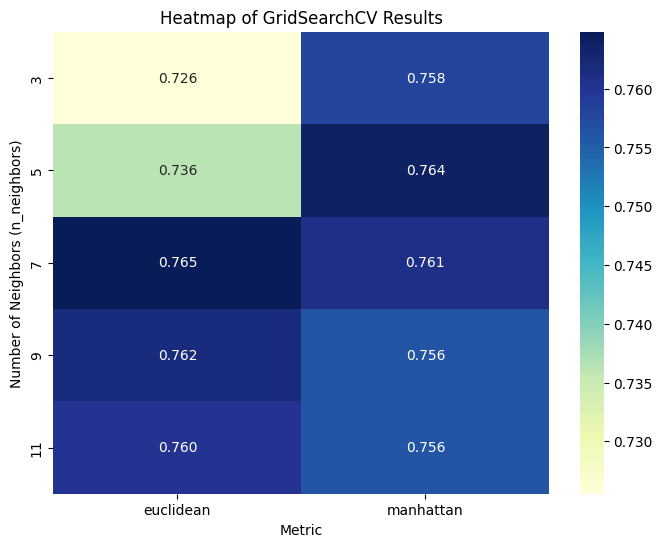

In [227]:
# Pivot tabel berdasarkan n_neighbors dan metric untuk visualisasi
pivot_table = grid_results.pivot_table(
    values='mean_test_score',
    index='param_n_neighbors',
    columns='param_metric',
    aggfunc=np.mean
)

# Menampilkan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f", cbar=True)
plt.title("Heatmap of GridSearchCV Results")
plt.xlabel("Metric")
plt.ylabel("Number of Neighbors (n_neighbors)")
plt.show()


In [229]:
# Menggunakan model terbaik dari grid search
best_knn = grid_search.best_estimator_

# Evaluasi pada data test
y_pred = best_knn.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86        88
           1       0.73      0.55      0.63        40

    accuracy                           0.80       128
   macro avg       0.77      0.73      0.74       128
weighted avg       0.79      0.80      0.79       128



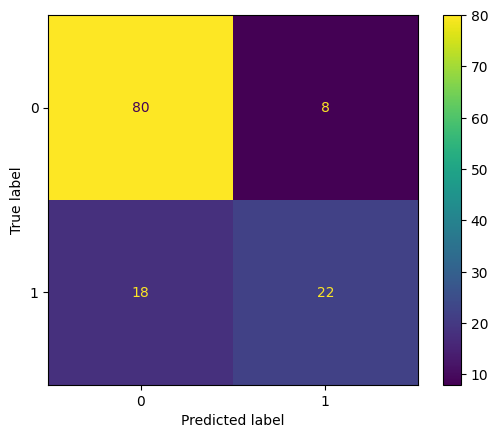

In [228]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_test and y_pred_best are defined from the previous code
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## Mencoba Model Deep Learning

In [213]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [214]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [215]:
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [216]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [217]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)




In [218]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5934 - loss: 0.7187 - val_accuracy: 0.3039 - val_loss: 3.8358
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6674 - loss: 0.6135 - val_accuracy: 0.3039 - val_loss: 4.7668
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7545 - loss: 0.5316 - val_accuracy: 0.3039 - val_loss: 3.8513
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7530 - loss: 0.5071 - val_accuracy: 0.3039 - val_loss: 2.9395
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7389 - loss: 0.4653 - val_accuracy: 0.3039 - val_loss: 2.2259
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7684 - loss: 0.4626 - val_accuracy: 0.3039 - val_loss: 1.7879
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7433 - loss: 0.4999 - val_accuracy: 0.3039 - val_loss: 1.5610
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7683 - loss: 0.4504 - val_accuracy: 0.3039 - val_loss:

In [219]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7729 - loss: 0.4850

Test Accuracy: 0.7500


In [220]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        88
           1       0.60      0.60      0.60        40

    accuracy                           0.75       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.75      0.75      0.75       128

Confusion Matrix:
 [[72 16]
 [16 24]]


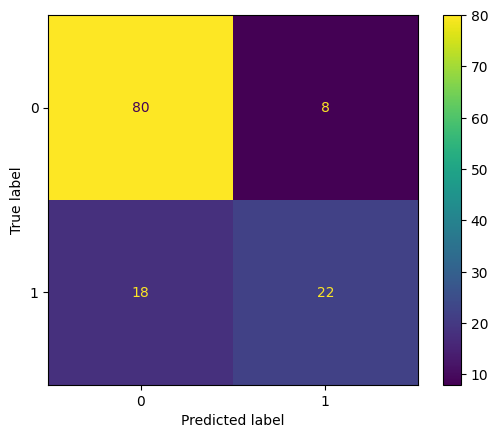

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


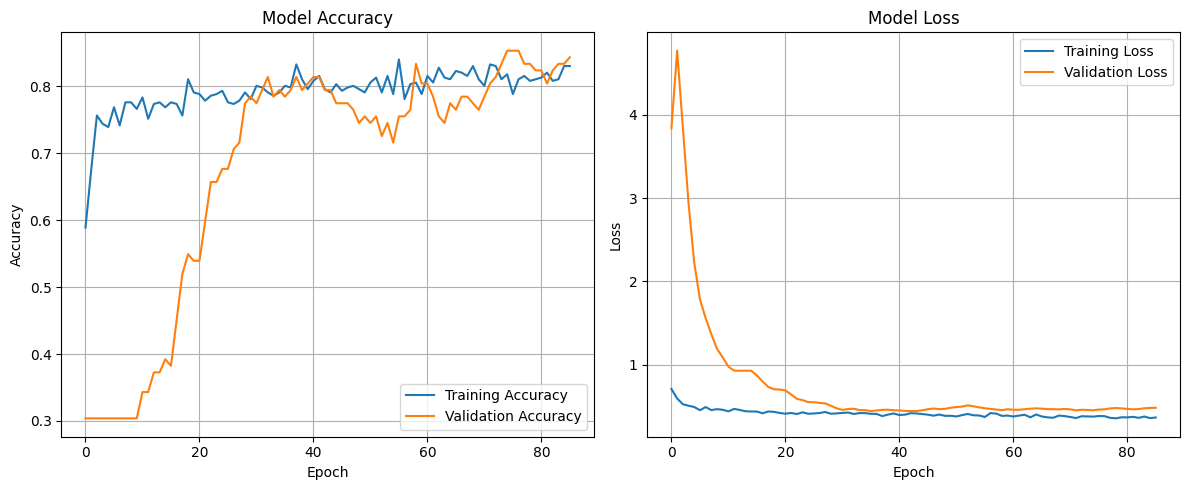

In [224]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
